# Tiền xử lý dữ liệu văn bản

## 1. Mô tả dữ liệu

- **Tên bộ dữ liệu**: Rumor Detection Dataset (Twitter15 and Twitter16)
  
- **Nguồn dữ liệu**: [Kaggle - Rumor Detection ACL 2017](https://www.kaggle.com/datasets/syntheticprogrammer/rumor-detection-acl-2017)
  
- **Kích thước & Định dạng**: Bộ dữ liệu bao gồm các file văn bản chứa dạng `.txt`, trong đó gồm có 2 file là
  - `source_tweets.txt`: chưa nội dung gốc của các tweet
  - `label.txt`: chứa nhãn ground-truth tương ứng cho các tweet
  
Mỗi dòng đại diện cho một sự kiện tin đồn với ID và nội dung văn bản tương ứng.
  
- **Mô tả**: Tập dữ liệu này cung cấp các tweet nguồn được gắn nhãn từ bộ dữ liệu Twitter15 và Twitter16, thường được sử dụng trong các nghiên cứu về phát hiện tin giả và tin đồn trên mạng xã hội
- Tiềm năng ứng dụng:
  - Phát hiện tin giả/tin đồn.
  - Phân tích cảm xúc trên mạng xã hội.
  - Phân tích sự lan truyền thông tin.

## 2. Chuẩn bị môi trường cần thiết

### 2.1 Chuẩn bị thư viện

In [2]:
import os
import pandas as pd
import numpy as np
import time
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk import pos_tag
from transformers import AutoTokenizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

try:
    nltk.data.find('corpora/stopwords')  
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('stopwords')                          # tải danh sách từ dừng
    nltk.download('punkt')                              # tải mô hình tách từ
    nltk.download('punkt_tab')                          # tải mô hình tách từ cho tweet
    nltk.download("wordnet")                            # tải dữ liệu WordNet cho lemmatization
    nltk.download('averaged_perceptron_tagger_eng')     # tải mô hình gán nhãn từ loại
    nltk.download('words')                              # tải danh sách từ tiếng Anh

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\MY PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to C:\Users\MY
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!

### 2.2 Chuẩn bị dữ liệu

In [3]:
def load_source_tweets(path: str) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            if not line:
                continue
            tweet_id, text = line.split("\t", 1)
            rows.append((tweet_id, text))
    return pd.DataFrame(rows, columns=["tweet_id", "text"])

BASE_DIR = "../data/text"

df15 = load_source_tweets(os.path.join(BASE_DIR, "twitter15", "source_tweets.txt"))
df15["dataset"] = "twitter15"

df16 = load_source_tweets(os.path.join(BASE_DIR, "twitter16", "source_tweets.txt"))
df16["dataset"] = "twitter16"

df_all = pd.concat([df15, df16], ignore_index=True)
print("Loaded tweets:", len(df_all))
df_all.sample(5)

Loaded tweets: 2308


,tweet_id,text,dataset
774,521790189715615744,stop believing what you see on facebook. rt @l...,twitter15
2087,656811196218286080,10 'back to the future' predictions that came ...,twitter16
286,692440373449396224,federal reserve declines to raise key interest...,twitter15
775,740748123581087745,first female candidate for president was not @...,twitter15
1623,706933939953344514,bernie sanders speaking about institutional ra...,twitter16


## 3. Tokenization

### 3.1 Cơ sở lý thuyết

Tokenization là bước chuyển đổi văn bản thô thành các đơn vị nhỏ hơn gọi là các tokens, giúp mô hình học máy có thể hiểu được cấu trúc văn bản, biểu diễn dữ liệu dưới dạng số cũng như trích xuất đặc trưng hiệu quả.

#### Tính cần thiết

Đối với dữ liệu dạng tweet, tokenization là bước đặc biệt cần thiết vì văn bản thường có tính phi chuẩn cao, bao gồm viết tắt, slang, hashtag, emoji, đường dẫn URL, và dấu câu xuất hiện dày đặc. Nếu xử lý văn bản ở dạng chuỗi thô, các mô hình NLP sẽ khó nhận diện ranh giới giữa các đơn vị ngôn ngữ có ý nghĩa, dẫn đến biểu diễn dữ liệu kém hiệu quả. Tokenization giúp chuẩn hóa và phân tách các thành phần trong văn bản, tạo nền tảng cần thiết cho các bước tiền xử lý tiếp theo

#### Lợi ích kỳ vọng

Tokenization giúp:

- Chuyển đổi văn bản sang dạng có cấu trúc, phù hợp với các phương pháp biểu diễn số như Bag-of-Words, TF-IDF hoặc embedding.
- Cho phép mô hình tập trung vào các đơn vị ngôn ngữ có ý nghĩa thay vì xử lý toàn bộ chuỗi ký tự, từ đó cải thiện khả năng học đặc trưng và hiệu suất mô hình.
- Hỗ trợ phát hiện các mẫu ngôn ngữ đặc trưng trong dữ liệu tweet chẳng hạn như hashtag, giúp tăng tính giải thích trong phân tích văn bản.

#### Một số hạn chế

Mặc dù cần thiết, tokenization cũng tồn tại một số hạn chế. Việc lựa chọn chiến lược tokenization không phù hợp có thể dẫn đến mất mát thông tin ngữ nghĩa, chẳng hạn như khi các cụm từ cố định bị tách rời hoặc các biểu thức đa từ bị xử lý không nhất quán. Đối với dữ liệu tweet, các phương pháp tokenization dựa trên quy tắc có thể gặp khó khăn với ngôn ngữ phi chuẩn, trong khi các phương pháp tokenization dựa trên mô hình (như subword tokenization) có thể làm tăng độ phức tạp tính toán và kích thước biểu diễn. Do đó, việc lựa chọn phương pháp tokenization cần được cân nhắc kỹ lưỡng dựa trên đặc điểm của tập dữ liệu và mục tiêu phân tích.

### 3.2 Các kỹ thuật Tokenization:

#### 3.2.1 NLTK Word Tokenization

Đây là kỹ thuật Tokenization tiêu chuẩn phổ biến nhất trong xử lý ngôn ngữ tự nhiên truyền thống, thường được sử dụng làm mốc so sánh cho các phương pháp phức tạp hơn. Trong NLTK, kỹ thuật này được thực hiện thông qua hàm `word_tokenize` của thư viện NLTK (Natural Language Toolkit), hoạt động dựa trên bộ quy tắc ngữ pháp Penn Treebank.

Đặc điểm:
- Loại Tokenization: Word-level Tokenization
- Mục tiêu: Tách từ và dấu câu theo quy tắc ngôn ngữ tiếng Anh, xử lý các từ viết tắt (ví dụ: "don't" → "do", "n't")

In [4]:
start_time = time.time()

# Chuyển sang list để tăng tốc độ xử lý
input_list = df_all['text'].tolist()

# Thực hiện tokenization
df_all['tokens_nltk'] = [word_tokenize(text) for text in input_list]

print(f"Thời gian xử lý: {time.time() - start_time:.4f} giây")

# --- Tính toán chỉ số để so sánh ---
# Tạo tập từ vựng để xem có bao nhiêu từ duy nhất
vocab_baseline = set([item for sublist in df_all['tokens_nltk'] for item in sublist])
avg_len_baseline = df_all['tokens_nltk'].apply(len).mean()

print(f"Kích thước từ vựng: {len(vocab_baseline)}")
print(f"Số token trung bình mỗi tweet: {avg_len_baseline:.2f}")
print("-" * 30)
print(df_all['text'][0])
print(df_all['tokens_nltk'][0])

Thời gian xử lý: 0.2230 giây
Kích thước từ vựng: 6297
Số token trung bình mỗi tweet: 18.18
------------------------------
🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL
['🔥ca', 'kkk', 'grand', 'wizard', '🔥', 'endorses', '@', 'hillaryclinton', '#', 'neverhillary', '#', 'trump2016', 'URL']


#### 3.2.2 NLTK TweetTokenization

TweetTokenizer là một bộ tách từ chuyên biệt được cung cấp trong thư viện NLTK, được thiết kế dành riêng cho văn bản mạng xã hội, đặc biệt là Twitter. Loại văn bản này thường chứa nhiều đặc trưng phi chuẩn như hashtags (#topic), mentions (@user), emoticons/emoji, và các từ được kéo dài để nhấn mạnh cảm xúc (ví dụ: “soooo happy”).

TweetTokenizer được triển khai trong `module nltk.tokenize.casual` và được mô tả chính thức trong tài liệu API của NLTK. Khác với các tokenizer truyền thống dựa trên ngữ pháp chuẩn, TweetTokenizer sử dụng tập hợp các quy tắc heuristic và biểu thức chính quy được thiết kế riêng cho “ngôn ngữ mạng”, nhằm giảm nhiễu và bảo toàn thông tin ngữ nghĩa quan trọng.

Loại Tokenization: Word-level Tokenization

**Ý nghĩa các tham số của kỹ thuật này**:

- `preserve_case (bool)`

  - Mặc định: True

  - Ý nghĩa: Giữ nguyên chữ hoa/chữ thường của văn bản gốc.

  - Nếu đặt False, toàn bộ token sẽ được chuyển về chữ thường (lowercase), giúp giảm kích thước từ vựng nhưng có thể làm mất thông tin nhấn mạnh.

- `reduce_len (bool)`

  - Mặc định: False

  - Ý nghĩa: Nếu True, các chuỗi ký tự lặp từ 3 lần trở lên sẽ được rút gọn về độ dài 3.

  - Ví dụ: "waaaaaay" → "waaay"

  - Mục đích: Chuẩn hóa từ vựng, giảm nhiễu do thói quen nhấn mạnh cảm xúc của người dùng.

- `strip_handles (bool)`

  - Mặc định: False

  - Ý nghĩa: Nếu True, các Twitter handle (chuỗi bắt đầu bằng @) sẽ bị loại bỏ khỏi kết quả tokenization.

  - Tham số này hữu ích khi mention không mang ý nghĩa ngữ cảnh cho bài toán.

In [5]:
# Khởi tạo TweetTokenizer
tk = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

start_time = time.time()

# chuyển các text sang list vì NLTK xử lý List Python nhanh hơn nhiều so với việc lặp qua Pandas Series
input_list = df_all['text'].tolist()

# Gọi hàm tokenize_sents
df_all['tokens_tweet'] = tk.tokenize_sents(input_list)

print(f"Thời gian xử lý: {time.time() - start_time:.4f} giây")

# --- Tính toán chỉ số để so sánh ---
vocab_tweet = set([item for sublist in df_all['tokens_tweet'] for item in sublist])
avg_len_tweet = df_all['tokens_tweet'].apply(len).mean()

print(f"Kích thước từ vựng: {len(vocab_tweet)}")
print(f"Số token trung bình mỗi tweet: {avg_len_tweet:.2f}")
print("-" * 30)

print(df_all['text'][0])
print(df_all['tokens_tweet'][0])

Thời gian xử lý: 0.1803 giây
Kích thước từ vựng: 6149
Số token trung bình mỗi tweet: 17.46
------------------------------
🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL
['🔥', 'ca', 'kkk', 'grand', 'wizard', '🔥', 'endorses', '#neverhillary', '#trump2016', 'url']


#### 3.2.3 BERTweet Tokenizer

BERTweet Tokenizer là kỹ thuật tokenization đi kèm với mô hình BERTweet (do VinAI phát triển và công bố tại EMNLP 2020), là một mô hình ngôn ngữ tiền huấn luyện dựa trên kiến trúc RoBERTa, được huấn luyện chuyên biệt trên khoảng 850 triệu tweets tiếng Anh. BERTweet được xem là một trong những phương pháp State-of-the-Art (SOTA) cho các bài toán xử lý ngôn ngữ tự nhiên trên dữ liệu Twitter.

Khác với 2 phương pháp trên chỉ ở mức word-level, BERTweet sử dụng Byte-Pair Encoding (BPE) là một dạng subword tokenization. Điểm đặc biệt là mô hình áp dụng bước tiền xử lý đặc thù cho Twitter (bảo toàn emoji, hashtag, mention, URL…), sau đó mới sử dụng BPE để phân rã từ, giúp giữ được ngữ nghĩa của văn bản mạng xã hội.

Loại Tokenization: Subword Tokenization

**Các tham số quan trọng**:

- `padding`: Thêm token [PAD] để các câu trong cùng batch có độ dài bằng nhau.

- `truncation`: Cắt bớt các chuỗi vượt quá độ dài tối đa của mô hình (mặc định 512)

- `max_length`: Độ dài cố định của chuỗi đầu ra; với dữ liệu Twitter, giá trị 128 tokens thường là phù hợp và hiệu quả.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

start_time = time.time()

# Chuyển sang list để kích hoạt Batch Processing
input_list = df_all['text'].tolist()

# Tokenize hàng loạt (Batch Encoding)
encoded_batch = tokenizer(
    input_list,
    padding=True,       # Thêm padding cho bằng độ dài
    truncation=True,    # Cắt nếu quá dài
    max_length=128,     # Giới hạn độ dài tweet
    return_tensors='np' # Trả về numpy array
)

# Lưu input_ids đại diện cho từ
df_all['input_ids_bertweet'] = list(encoded_batch['input_ids'])

print(f"Thời gian xử lý: {time.time() - start_time:.4f} giây")

all_ids = encoded_batch['input_ids'].flatten()
unique_ids = set(all_ids)
# Loại bỏ các token rác hệ thống (0, 1, 2) khỏi tập từ vựng thực tế
vocab_bertweet = {i for i in unique_ids if i not in [0, 1, 2]}

# Tính số token trung bình mỗi tweet (Average Token Length)
def count_real_tokens(ids):
    # Chỉ đếm các token không phải là padding (1) và special (0, 2)
    return np.sum((ids != 0) & (ids != 1) & (ids != 2))

real_token_counts = np.apply_along_axis(count_real_tokens, 1, encoded_batch['input_ids'])
avg_token_len = np.mean(real_token_counts)

print(f"Kích thước từ vựng (Unique Tokens/Subwords): {len(vocab_bertweet)}")
print(f"Số token trung bình mỗi tweet: {avg_token_len:.2f}")
print("-" * 30)

# Hiển thị thử 1 mẫu
sample_idx = 0
print(f"Gốc: {input_list[sample_idx]}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(df_all['input_ids_bertweet'][sample_idx])}")

Thời gian xử lý: 0.8505 giây
Kích thước từ vựng (Unique Tokens/Subwords): 6477
Số token trung bình mỗi tweet: 20.19
------------------------------
Gốc: 🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL
Tokens: ['<s>', ':fire:', 'ca', 'kkk', 'grand', 'wizard', ':fire:', 'endorses', '@USER', '#never@@', 'hillary', '#trump@@', '2016', 'URL', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

### 3.3 So sánh và đánh giá

Bảng so sánh:

|Chỉ số |NLTK Word | NLTK Tweet| BERTweet|
|---|---|---|---|
|Thời gian xử lý |	0.2103s  |	0.1796s (Nhanh nhất) |	0.9102s (Chậm nhất) |
|Kích thước từ vựng |	6297 |	6103 (Nhỏ nhất - Tối ưu nhất) |	6477 |
|Số token TB/tweet |	18.18 |	17.66 (Ngắn nhất) |	20.19 (Dài nhất) |
|Xử lý Emoji |	Giữ nguyên 🔥 |	Giữ nguyên 🔥 |	Chuyển đổi thành text :fire: |

#### 3.3.1 Về tốc độ:

- NLTK TweetTokenizer thể hiện hiệu suất vượt trội qua việc thiết lập các tham số chuyên biệt cho Twitter giúp bộ lọc thực hiện cắt chuỗi cực kỳ tối ưu, nhanh hơn cả phương pháp Word Tokenization thông thường.

- NLTK Word Tokenization đạt tốc độ trung bình với việc xử lý dựa trên các quy tắc Regex tiêu chuẩn.

- BERTweet chậm hơn khoảng 5 lần so với NLTK. Điều này là tất yếu do cơ chế Subword Segmentation (BPE) phức tạp và việc phải tra cứu bảng từ vựng khổng lồ thay vì chỉ tách chuỗi dựa trên khoảng trắng và dấu câu.

#### 3.3.2 Về kích thước từ vựng:

- NLTK TweetTokenizer đạt hiệu quả tối ưu nhất (6103 từ). Nhờ tham số reduce_len=True (chuẩn hóa từ kéo dài) và preserve_case=False (chuyển về chữ thường), kỹ thuật này đã gộp các biến thể (ví dụ: "COOL", "cool", "coool") về cùng một gốc, giúp giảm chiều dữ liệu tốt nhất cho các thuật toán cổ điển.

- BERTweet có kích thước từ vựng lớn nhất (6477). Điều này phản ánh đặc trưng của Subword Tokenization: nó không chỉ chứa từ đơn mà còn chứa cả các mảnh từ và các token đặc thù (:fire:), làm tăng số lượng loại token.

#### 3.3.3 Về độ dài token trung bình:

- BERTweet có số token trung bình cao nhất (20.19). Đây là minh chứng rõ ràng cho cơ chế Subword Tokenization. Một từ đơn có thể bị phân rã thành nhiều subword units (tuỳ theo BPE vocabulary), bao gồm các subword units và các token nội dung đặc thù Twitter (như emoji được chuẩn hoá), dẫn đến số lượng token types lớn hơn.

- NLTK TweetTokenizer cho chuỗi ngắn nhất (17.66) do đã loại bỏ bớt nhiễu và giữ nguyên các cụm từ mạng xã hội.

#### 3.3.4 Đánh giá

1. Đối với `NLTK TweetTokenizer`: đây là lựa chọn tối ưu cho Preprocessing truyền thống. Phương pháp này thể hiện sự phù hợp nhất để làm sạch dữ liệu cho các tác vụ thống kê hoặc Machine Learning cơ bản nhờ các ưu điểm sau:

  - Giảm chiều dữ liệu hiệu quả nhất: Với kích thước từ vựng nhỏ nhất (6103), kỹ thuật này đã loại bỏ thành công các biến thể nhiễu.
  - Bảo toàn cấu trúc mạng xã hội: Khác với NLTK Word (Baseline) thường tách sai hashtag, TweetTokenizer giữ nguyên vẹn cấu trúc này, điều này rất quan trọng nếu cần phân tích Topic Modeling dựa trên hashtag.

2. Đối với `BERTweet Tokenizer`: đây là lựa chọn tối ưu cho Học sâu/ Phân tích cảm xúc. Mặc dù thời gian xử lý lâu hơn, nhưng đây là kỹ thuật vượt trội về khả năng hiểu ngữ nghĩa đối với dataset này:

  - Chuẩn hóa ngữ nghĩa: Ưu điểm lớn nhất quan sát được là khả năng "dịch" emoji thành văn bản. Ví dụ: mẫu tweet chứa 🔥 được chuyển thành :fire:. Điều này cung cấp thông tin cảm xúc tường minh cho mô hình, thay vì để lại một ký tự Unicode vô nghĩa như hai phương pháp trên.
  - Xử lý OOV (Out-of-Vocabulary): Với cơ chế Subword (BPE), BERTweet không bao giờ gặp từ lạ. Các từ lóng hoặc tên riêng trong dataset Twitter sẽ được phân rã thành các subword đã biết, giúp mô hình không bị mất thông tin.

Do đó, với kích thước từ vựng nhỏ nhất cũng như số token trung bình mỗi tweet thấp nhất giúp giảm nhiễu hiệu quả cũng như giữ được cấu trúc mạng xã hội khá tôi, kết quả được xử lý bởi kỹ thuật `NLTK TweetTokenization` sẽ được sử dụng cho các bước tiền xử lý tiếp theo. 

## 4. Loại bỏ stop words

### 4.1 Cơ sở lý thuyết 

Trong quá trình tiền xử lý văn bản, việc loại bỏ các stop words là rất quan trọng để nâng cao chất lượng và hiệu quả phân tích. Stop words là những từ phổ biến như *“the"*, *“is”* và *“and”* xuất hiện thường xuyên trong văn bản nhưng mang ít ý nghĩa ngữ nghĩa. Bằng cách loại bỏ các stop words sẽ giúp giảm nhiễu trong dữ liệu, giảm số chiều của tập dữ liệu và cải thiện độ chính xác của các tác vụ NLP như phân tích cảm xúc, mô hình hóa chủ đề và phân loại văn bản. Quá trình này hợp lý hóa việc phân tích bằng cách tập trung vào các từ quan trọng mang thông tin có ý nghĩa hơn, dẫn đến hiệu suất mô hình và diễn giải kết quả tốt hơn.

#### Tính cần thiết

Đối với dataset dạng tweet, việc loại bỏ stop words là đặc biệt cần thiết vì văn bản thường ngắn, phi chuẩn và chứa nhiều thành phần không mang ý nghĩa phân tích như từ chức năng, ký hiệu đặc biệt hoặc các token lặp lại. Ngoài ra, ta có thể thấy trong dataset này, token “url” xuất hiện ở hầu hết các dòng do đường dẫn đã được chuẩn hóa sẵn, nhưng bản thân nó không mang giá trị ngữ nghĩa liên quan đến nội dung của tweet. Bên cạnh đó, sau bước tokenization, các dấu câu vẫn còn tồn tại trong dữ liệu và có xu hướng xuất hiện với tần suất cao, gây nhiễu cho phân tích thống kê từ vựng. Do bài này không có bước xử lý dấu câu riêng biệt, việc xem dấu câu như một loại stop word để loại bỏ là cần thiết nhằm làm sạch dữ liệu và cải thiện chất lượng đầu vào cho các bước tiếp theo.

#### Lợi ích kỳ vọng

Việc loại bỏ stop words giúp giảm đáng kể số lượng token trong corpus, từ đó làm giảm độ nhiễu và giảm số chiều của không gian đặc trưng trong bước vectorization như Bag-of-Words hoặc TF-IDF. Điều này giúp mô hình tập trung nhiều hơn vào các từ mang nội dung, cải thiện khả năng học đặc trưng và hiệu suất trong các tác vụ NLP như phân tích cảm xúc, mô hình hóa chủ đề và phân loại văn bản. Ngoài ra, việc loại bỏ các token không mang ý nghĩa như “url” và dấu câu giúp phân phối tần suất từ phản ánh rõ ràng hơn các chủ đề thực sự của dữ liệu, qua đó nâng cao khả năng diễn giải kết quả phân tích.

#### Một số hạn chế

Tuy nhiên, việc loại bỏ stop words có thể gây bất lợi trong bài toán phát hiện tin đồn. Một số từ chức năng thể hiện mức độ chắc chắn hoặc nghi ngờ (ví dụ các dạng giảm nhẹ, phỏng đoán) có thể mang tín hiệu quan trọng để nhận diện tin đồn; việc loại bỏ chúng có thể làm mất thông tin hữu ích cho mô hình. Ngoài ra, việc loại bỏ các token như dấu câu có thể làm mất một số tín hiệu gián tiếp về hành vi lan truyền hoặc sắc thái biểu cảm vốn thường xuất hiện trong tin đồn. Cuối cùng, việc loại bỏ quá nhiều từ chức năng có thể làm suy yếu các mẫu tương tác trong dữ liệu dạng reply/thread, vốn có thể giúp phân biệt giữa thông tin được cộng đồng xác nhận và tin đồn.

### 4.2 Xác định các stop word phố biến trong dataset

In [7]:
# Thêm từ "url" và các dấu câu vào danh sách stop words
stop_words.update(['url', '.', ',', '!', '?', ';', ':', '-', '_', '(', ')', '[', ']', '{', '}', '"', "'", '...', '’'])

# Lấy tất cả token từ kết quả TweetTokenizer
all_tokens_tweet = [token for sublist in df_all['tokens_tweet'] for token in sublist]

# Tìm các stop words xuất hiện trong dữ liệu và tần suất của chúng
stop_words_found = [w for w in all_tokens_tweet if w in stop_words]
stop_words_dist = nltk.FreqDist(stop_words_found)

print(f"Số lượng stop words khác nhau xuất hiện trong dữ liệu: {len(set(stop_words_found))}")
print("Top 10 từ dừng xuất hiện nhiều nhất:")
for word, count in stop_words_dist.most_common(10):
    print(f"- {word}: {count} lần")


Số lượng stop words khác nhau xuất hiện trong dữ liệu: 177
Top 10 từ dừng xuất hiện nhiều nhất:
- url: 2990 lần
- .: 1286 lần
- the: 861 lần
- ,: 815 lần
- :: 796 lần
- in: 748 lần
- to: 725 lần
- a: 641 lần
- of: 573 lần
- ": 548 lần


### 4.3 Loại bỏ stop words

In [8]:
# Hàm thực hiện loại bỏ stop words
def remove_stop_words(tokens):
    return [w for w in tokens if w not in stop_words]

df_all['tokens_no_stop'] = df_all['tokens_tweet'].apply(remove_stop_words)

# Kiểm tra xem kết quả sau khi loại bỏ stop words
print(df_all['tokens_tweet'][1])
print(df_all['tokens_no_stop'][1])

['an', 'open', 'letter', 'to', 'trump', 'voters', 'from', 'his', 'top', 'strategist-turned-defector', 'url', 'via']
['open', 'letter', 'trump', 'voters', 'top', 'strategist-turned-defector', 'via']


### 4.4 Đánh giá tác động

#### 4.4.1 Đối với kích thước từ vựng

In [9]:
def vocab_stats(tokens):
    N = len(tokens)
    V = len(set(tokens))
    return {"N": N, "V": V}

# danh sách tokens trước khi loại bỏ stop words
tokens_before = [token for sublist in df_all['tokens_tweet'] for token in sublist]
tokens_after = [token for sublist in df_all['tokens_no_stop'] for token in sublist]

# Tính toán chỉ số trước và sau khi loại bỏ stop words
stats_before = vocab_stats(tokens_before)
stats_after = vocab_stats(tokens_after)
vocab_reduction = (stats_before["V"] - stats_after["V"]) / stats_before["V"] * 100
token_reduction = (stats_before["N"] - stats_after["N"]) / stats_before["N"] * 100

print("Thống kê từ vựng trước khi loại bỏ stop words:")
print(f"- Tổng số token (N): {stats_before['N']}")
print(f"- Số từ duy nhất (V): {stats_before['V']}") 
print("Thống kê từ vựng sau khi loại bỏ stop words:")
print(f"- Tổng số token (N): {stats_after['N']}")
print(f"- Số từ duy nhất (V): {stats_after['V']}")

print(f"Tỉ lệ giảm của từ vựng: {vocab_reduction:.2f}%")
print(f"Tỉ lệ giảm của tổng số token: {token_reduction:.2f}%")

Thống kê từ vựng trước khi loại bỏ stop words:
- Tổng số token (N): 40299
- Số từ duy nhất (V): 6149
Thống kê từ vựng sau khi loại bỏ stop words:
- Tổng số token (N): 22416
- Số từ duy nhất (V): 5972
Tỉ lệ giảm của từ vựng: 2.88%
Tỉ lệ giảm của tổng số token: 44.38%


Kết quả cho thấy sau khi loại bỏ các stop word, tổng số token giảm đáng kể từ 40757 xuống 22874 (giảm 43.88%), trong khi kích thước từ vựng chỉ giảm nhẹ từ 6403 xuống 6226 (giảm 2.76%). Điều này chỉ ra rằng các stop word chủ yếu chiếm tỷ trọng lớn về tần suất xuất hiện, nhưng không đóng góp nhiều vào độ đa dạng từ vựng. Do đó, việc loại bỏ các stop word giúp giảm nhiễu và kích thước dữ liệu mà vẫn giữ lại phần lớn thông tin từ vựng của corpus.

#### 4.4.2 Đối với khả năng giữ lại thông tin

Để đánh giá tác động của việc loại bỏ stop words lên khả năng giữ lại thông tin, ta sẽ phân tích sự thay đổi trong các từ có tần suất xuất hiện cao nhất trước và sau khi xử lý. Cụ thể, danh sách Top 10 từ xuất hiện nhiều nhất trong toàn bộ corpus được trích xuất ở hai phiên bản dữ liệu: trước khi loại bỏ stop words và sau khi loại bỏ stop words. Việc so sánh hai danh sách này cho phép kiểm tra xem các token chứa nội dung có chiếm ưu thế hay không, đồng thời xác nhận liệu stop words có thực sự bị loại bỏ khỏi nhóm từ phổ biến nhất hay không.

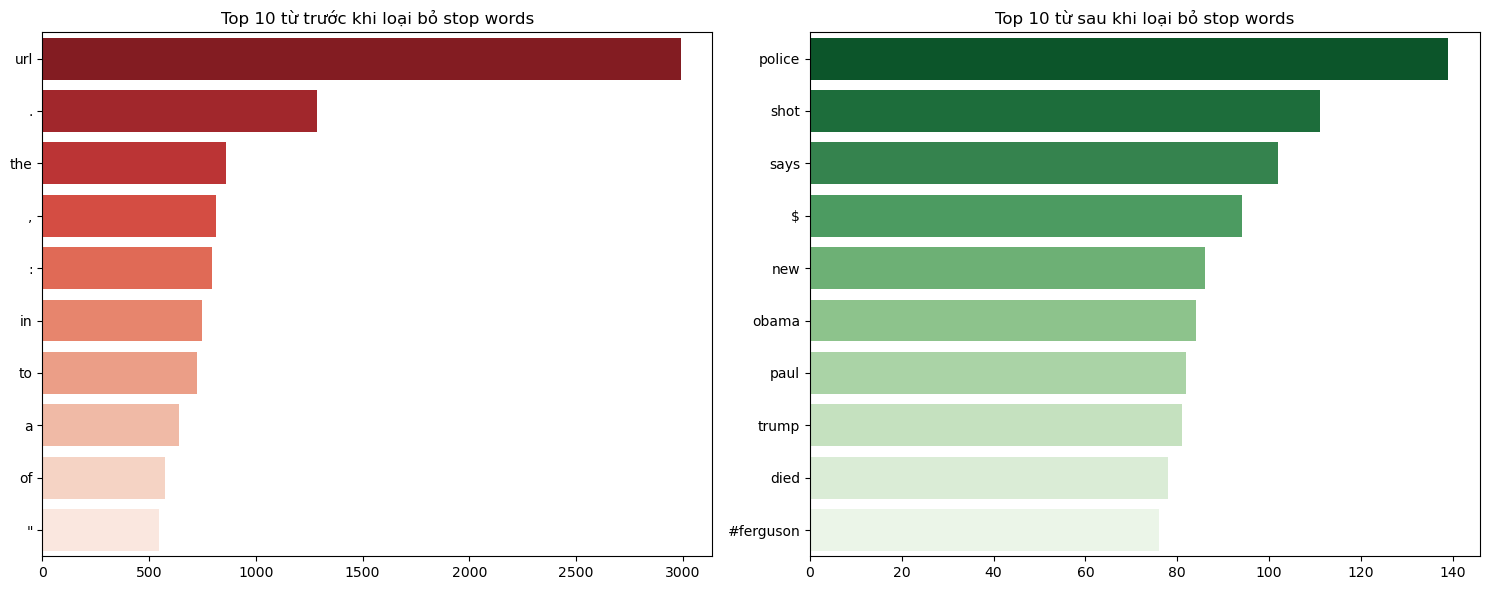

In [10]:
def plot_top_words_comparison(raw_tokens_list, clean_tokens_list, top_n=10):
    raw_flat = [word for sublist in raw_tokens_list for word in sublist]
    clean_flat = [word for sublist in clean_tokens_list for word in sublist]
    
    # Đếm tần suất từ
    cnt_raw = Counter(raw_flat).most_common(top_n)
    cnt_clean = Counter(clean_flat).most_common(top_n)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Biểu đồ cho dữ liệu trước khi loại bỏ stop words
    sns.barplot(
        x=[val[1] for val in cnt_raw], 
        y=[val[0] for val in cnt_raw],
        hue=[val[0] for val in cnt_raw],
        ax=axes[0],
        palette="Reds_r",
        legend=False
    )
    axes[0].set_title(f"Top {top_n} từ trước khi loại bỏ stop words")
    
    # Biểu đồ cho dữ liệu đã loại bỏ stop words
    sns.barplot(
        x=[val[1] for val in cnt_clean], 
        y=[val[0] for val in cnt_clean],
        hue=[val[0] for val in cnt_clean],
        ax=axes[1],
        palette="Greens_r",
        legend=False
    )
    axes[1].set_title(f"Top {top_n} từ sau khi loại bỏ stop words")
    
    plt.tight_layout()
    plt.show()

plot_top_words_comparison(df_all['tokens_tweet'], df_all['tokens_no_stop'], top_n=10)

Kết quả Top 10 từ cho thấy việc loại bỏ stop words đã loại bỏ các từ chức năng tần suất cao, làm nổi bật các từ mang nội dung liên quan trực tiếp đến chủ đề của dữ liệu (như police, shot, obama, trump, #ferguson), qua đó cải thiện khả năng phản ánh thông tin ngữ nghĩa của corpus

## 5.  Stemming và Lemmatization

### 5.1 Stemming

#### 5.1.1 Cơ sở lý thuyết

Stemming là kỹ thuật chuẩn hóa từ trong xử lý ngôn ngữ tự nhiên nhằm rút gọn các từ về dạng gốc bằng cách loại bỏ các tiền tố, hậu tố hoặc biến thể hình thái học. Ví dụ, các từ như “argue”, “argued”, “arguing” có thể được rút về cùng một dạng gốc “argu”. Mục tiêu của stemming là giảm tính đa dạng hình thái của từ vựng trong văn bản, từ đó đơn giản hóa biểu diễn dữ liệu cho các mô hình học máy.

#### Tính cần thiết

Trong dữ liệu phát hiện tin đồn (đặc biệt là dữ liệu từ mạng xã hội như Twitter), người dùng thường sử dụng nhiều biến thể của cùng một từ do chia thì, viết tắt, kéo dài từ (ví dụ như “confirm”, “confirmed”, “confirming”). Nếu không chuẩn hóa, cùng một khái niệm có thể bị xem là các token khác nhau, làm tăng tính sparsity của dữ liệu và khiến mô hình khó học được các mẫu ngôn ngữ liên quan đến tin đồn. Do đó, stemming giúp gom nhóm các biến thể từ vựng có cùng ý nghĩa cơ bản, hỗ trợ mô hình nhận diện tốt hơn các tín hiệu ngôn ngữ đặc trưng của tin đồn.

#### Lợi ích kỳ vọng

- Việc hợp nhất các dạng biến thể của cùng một từ giúp giảm số lượng đặc trưng trong mô hình, giúp giảm kích thước từ vựng.

- Mô hình có thể học được các mẫu ngôn ngữ ổn định hơn thay vì phụ thuộc vào từng dạng chia từ cụ thể, góp phần giúp tăng khả năng tổng quát hóa 

- Ít features hơn giúp giảm chi phí lưu trữ và thời gian huấn luyện mô hình, giúp cải thiện hiệu quả tính toán: 

#### Một số hạn chế

- Mất thông tin ngữ nghĩa tinh vi: Stemming dựa trên quy tắc cắt đuôi từ nên có thể tạo ra các stem không phải từ có nghĩa thực sự (như “argu”), gây khó khăn cho diễn giải kết quả.

- Gộp nhầm các từ khác nghĩa: Các từ có hình thái tương tự nhưng mang nghĩa khác nhau có thể bị rút về cùng một stem, làm nhiễu mô hình.

- Không phù hợp với mọi ngữ cảnh tin đồn: Trong rumor detection, sự khác biệt giữa các dạng từ (ví dụ mức độ khẳng định như “confirm” vs “confirmed”) đôi khi mang tín hiệu quan trọng; stemming có thể làm mất những sắc thái này.

- Phụ thuộc vào ngôn ngữ và thuật toán: Kết quả stemming có thể khác nhau giữa các thuật toán (Porter, Snowball), ảnh hưởng đến hiệu suất mô hình.

#### 5.1.2 Thuật toán Porter và Snowball

1. Porter Stemmer

Thuật toán Porter Stemmer (1980) là một trong những phương pháp stemming cổ điển và phổ biến nhất trong NLP. Nó hoạt động dựa trên một tập hợp các quy tắc thủ công để loại bỏ hậu tố của từ tiếng Anh theo từng bước.

2. Snowball Stemmer

Snowball Stemmer là phiên bản cải tiến của Porter, khắc phục một số lỗi của Porter Stemmer gốc.

Cải tiến chính:

- Chuẩn hóa tốt hơn (ít tạo ra stem vô nghĩa hơn Porter).

- Xử lý một số hậu tố phức tạp chính xác hơn.

- Vẫn là rule-based nhưng ổn định hơn cho dữ liệu mạng xã hội.

In [11]:
# Khởi tạo bộ stemmers
porter = PorterStemmer()
snowball = SnowballStemmer("english")

# hàm áp dụng stemming
def apply_stemming(tokens, method='porter'):
    stemmer = porter if method == 'porter' else snowball
    return [stemmer.stem(t) for t in tokens]

# áp dụng lên dữ liệu
df_all['tokens_stem_porter'] = df_all['tokens_no_stop'].apply(lambda tokens: apply_stemming(tokens, method='porter'))
df_all['tokens_stem_snowball'] = df_all['tokens_no_stop'].apply(lambda tokens: apply_stemming(tokens, method='snowball'))

# Hiển thị kết quả thử nghiệm
print("Original Tokens:", df_all['tokens_no_stop'][3])
print("Porter Stemmed:", df_all['tokens_stem_porter'][3])
print("Snowball Stemmed:", df_all['tokens_stem_snowball'][3])

Original Tokens: ['brandon', 'marshall', 'visits', 'offers', 'advice', 'support', 'brother', 'fallen', 'hero', 'zaevion', 'dobson']
Porter Stemmed: ['brandon', 'marshal', 'visit', 'offer', 'advic', 'support', 'brother', 'fallen', 'hero', 'zaevion', 'dobson']
Snowball Stemmed: ['brandon', 'marshal', 'visit', 'offer', 'advic', 'support', 'brother', 'fallen', 'hero', 'zaevion', 'dobson']


### 5.2 Lemmatization

#### 5.2.1 Cơ sở lý thuyết

Lemmatization là kỹ thuật chuẩn hóa từ trong xử lý ngôn ngữ tự nhiên nhằm đưa các từ về dạng cơ sở có nghĩa dựa trên phân tích hình thái học và ngữ cảnh ngữ pháp. Khác với stemming chỉ cắt bỏ hậu tố theo quy tắc, lemmatization xem xét vai trò ngữ pháp của từ để đảm bảo dạng gốc vẫn là một từ hợp lệ trong từ điển. Ví dụ, các từ như “argue”, “argued”, “arguing” sẽ được đưa về cùng một dạng gốc “argue”. Mục tiêu của lemmatization là chuẩn hóa hình thái từ vựng trong khi vẫn bảo toàn ý nghĩa ngôn ngữ, giúp mô hình học máy biểu diễn văn bản chính xác hơn.

#### Tính cần thiết

Trong dữ liệu phát hiện tin đồn (đặc biệt là dữ liệu từ mạng xã hội như Twitter), người dùng thường sử dụng nhiều biến thể của cùng một từ do chia thì, viết tắt, hoặc phong cách viết không chuẩn. Nếu không chuẩn hóa, cùng một khái niệm có thể bị xem là các token khác nhau, làm tăng tính sparsity và gây khó khăn cho mô hình trong việc học các mẫu liên quan đến tin đồn. Lemmatization giúp gom nhóm các biến thể từ vựng về dạng có nghĩa chung, đồng thời vẫn giữ được tính đúng đắn về mặt ngữ pháp, từ đó hỗ trợ mô hình nhận diện các tín hiệu ngôn ngữ quan trọng trong bài toán rumor detection.

#### Lợi ích kỳ vọng

- Giảm kích thước từ vựng một cách có kiểm soát bằng cách hợp nhất các dạng biến thể của cùng một từ mà vẫn giữ nguyên nghĩa gốc.

- Cải thiện chất lượng biểu diễn ngữ nghĩa của văn bản, giúp mô hình học được các mẫu ngôn ngữ ổn định hơn thay vì phụ thuộc vào từng dạng chia từ cụ thể.

- Tăng khả năng tổng quát hóa của mô hình, đặc biệt trong các tác vụ yêu cầu hiểu ngữ nghĩa như phân loại tin đồn.

- Giảm nhiễu do biến thể hình thái học nhưng vẫn duy trì tính diễn giải của kết quả (lemma vẫn là từ có nghĩa).

#### Một số hạn chế

- Chi phí tính toán cao hơn: Lemmatization (đặc biệt khi có POS-tagging) tốn nhiều thời gian xử lý hơn so với stemming, có thể ảnh hưởng đến hiệu suất trên tập dữ liệu lớn.

- Phụ thuộc vào chất lượng gán nhãn từ loại: Nếu POS-tagging không chính xác (đặc biệt trên dữ liệu mạng xã hội nhiều lỗi chính tả), kết quả lemmatization có thể bị sai lệch.

- Không xử lý tốt tiếng lóng và viết tắt: Trong dữ liệu Twitter, nhiều từ không chuẩn hoặc slang có thể không được lemmatizer nhận diện chính xác.

- Có thể giữ lại quá nhiều biến thể hình thái: So với stemming, lemmatization thường giảm từ vựng ít hơn, dẫn đến không giảm chiều dữ liệu mạnh bằng.

#### 5.2.2 Các kỹ thuật Lemmatization

1. NLTK WordNet Lemmatizer

NLTK WordNet Lemmatizer chuẩn hóa từ về dạng lemma bằng cách tra cứu trong từ điển WordNet. Độ chính xác phụ thuộc vào nhãn từ loại (POS) vì cùng một từ có thể có lemma khác nhau tùy vai trò ngữ pháp (ví dụ: running $\rightarrow$ run nếu là động từ, nhưng giữ nguyên nếu là danh từ).

**Các tham số:**
- `word`: token cần chuẩn hóa
- `pos`: nhãn từ loại ('n', 'v', 'a', 'r')

In [12]:
# Khởi tạo bộ lemmatizer
lemmatizer = WordNetLemmatizer()

# Hàm lấy POS tag theo định dạng WordNet
def get_wordnet_pos(tag):
    if tag.startswith("J"): return "a"
    elif tag.startswith("V"): return "v"
    elif tag.startswith("R"): return "r"
    else: return "n"

# Hàm thực hiện lemmatization với POS tagging
def lemma_nltk(tokens):
    tagged = pos_tag(tokens)
    return [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in tagged]

# Áp dụng lemmatization
df_all["tokens_lemma_nltk"] = df_all["tokens_no_stop"].apply(lemma_nltk)

# Hiển thị kết quả thử nghiệm
print("Original Tokens:", df_all['tokens_no_stop'][3])
print("Lemmatized Tokens:", df_all['tokens_lemma_nltk'][3])

Original Tokens: ['brandon', 'marshall', 'visits', 'offers', 'advice', 'support', 'brother', 'fallen', 'hero', 'zaevion', 'dobson']
Lemmatized Tokens: ['brandon', 'marshall', 'visit', 'offer', 'advice', 'support', 'brother', 'fall', 'hero', 'zaevion', 'dobson']


2. spaCy Lemmatization

spaCy sử dụng mô hình ngôn ngữ thống kê để dự đoán lemma dựa trên ngữ cảnh của toàn câu, không chỉ tra cứu từ điển. Vì vậy xử lý tốt hơn các biến thể ngôn ngữ và văn bản mạng xã hội.

**Các tham số:**
nlp = spacy.load(model)
- `en_core_web_sm`: cân bằng giữa tốc độ và chất lượng
- `en_core_web_trf`: chính xác hơn nhưng nặng

In [13]:
# Khởi tạo mô hình spaCy
nlp = spacy.load("en_core_web_sm")

# Hàm thực hiện lemmatization sử dụng spaCy
def lemma_spacy(tokens):
    doc = nlp(" ".join(tokens))   # ghép lại để giữ ngữ cảnh
    return [token.lemma_ for token in doc]

# Áp dụng lemmatization với spaCy
df_all["tokens_lemma_spacy"] = df_all["tokens_no_stop"].apply(lemma_spacy)

# Hiển thị kết quả thử nghiệm
print("Original Tokens:", df_all['tokens_no_stop'][3])
print("Lemmatized Tokens:", df_all['tokens_lemma_spacy'][3])

Original Tokens: ['brandon', 'marshall', 'visits', 'offers', 'advice', 'support', 'brother', 'fallen', 'hero', 'zaevion', 'dobson']
Lemmatized Tokens: ['brandon', 'marshall', 'visit', 'offer', 'advice', 'support', 'brother', 'fall', 'hero', 'zaevion', 'dobson']


### 5.3 Kết quả và đánh giá

#### 5.3.1 Khả năng giảm kích thước từ vựng

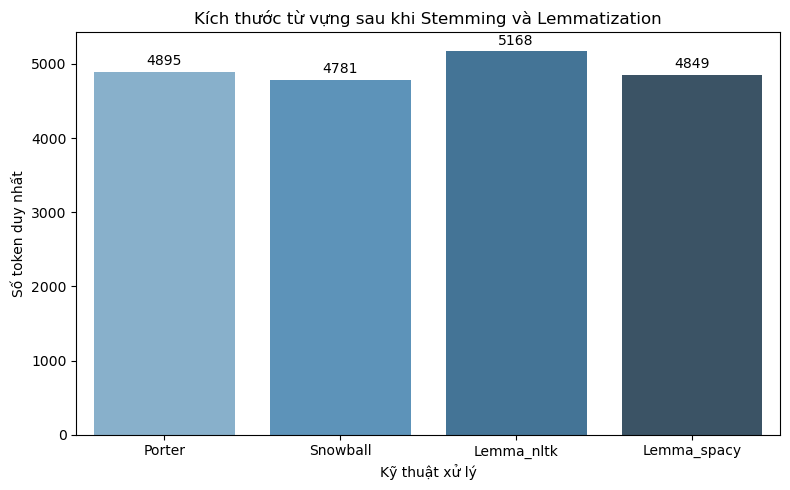

In [14]:
# Tính kích thước từ vựng sau các phương pháp xử lý
vocab_sizes = {
    "Porter": len(set([token for sublist in df_all['tokens_stem_porter'] for token in sublist])),
    "Snowball": len(set([token for sublist in df_all['tokens_stem_snowball'] for token in sublist])),
    "Lemma_nltk": len(set([token for sublist in df_all['tokens_lemma_nltk'] for token in sublist])),
    "Lemma_spacy": len(set([token for sublist in df_all['tokens_lemma_spacy'] for token in sublist]))
}

# Trực quan hóa kích thước từ vựng sau các phương pháp xử lý
plt.figure(figsize=(8,5))
sns.barplot(x=list(vocab_sizes.keys()), y=list(vocab_sizes.values()), hue=list(vocab_sizes.keys()), palette="Blues_d", legend=False)
for i, v in enumerate(vocab_sizes.values()):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')
plt.title("Kích thước từ vựng sau khi Stemming và Lemmatization")
plt.ylabel("Số token duy nhất")
plt.xlabel("Kỹ thuật xử lý")
plt.tight_layout()
plt.show()


**Nhận xét**:
- Snowball (4781) cho mức giảm từ vựng mạnh nhất, cho thấy khả năng chuẩn hóa và gom nhóm biến thể tốt hơn Porter.
- Porter (4895) giảm từ vựng đáng kể nhưng kém Snowball, gợi ý còn dư thừa hoặc tạo nhiều stem khác nhau hơn.
- NLTK Lemmatizer (5168) giữ lại từ vựng lớn nhất, phản ánh việc bảo toàn hình thái và ngữ nghĩa tốt hơn nhưng ít giảm chiều hơn.
- spaCy Lemmatizer (4849) đạt sự cân bằng tốt, gần với Snowball về giảm chiều nhưng vẫn giữ dạng từ hợp lệ tốt hơn stemming.

#### 5.3.2 Tỉ lệ từ vô nghĩa 

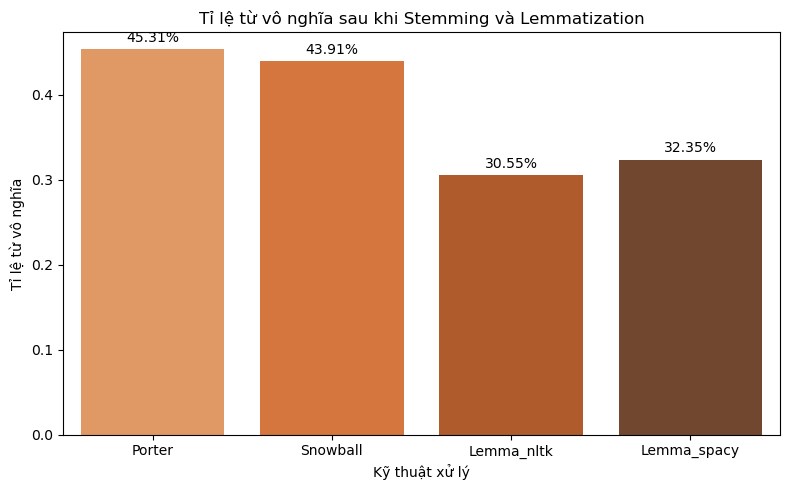

In [15]:
# Thêm tập từ vựng tiếng Anh từ NLTK
english_words = set(nltk.corpus.words.words())

# Hàm tính tỉ lệ từ vô nghĩa
def non_word_ratio(token_lists):
    tokens = [t for doc in token_lists for t in doc]
    non_words = sum(1 for t in tokens if t not in english_words)
    return non_words / len(tokens)

# Tính tỉ lệ từ vô nghĩa sau các phương pháp xử lý
nw_porter = non_word_ratio(df_all['tokens_stem_porter'])
nw_snowball = non_word_ratio(df_all['tokens_stem_snowball'])
nw_lemma_nltk = non_word_ratio(df_all['tokens_lemma_nltk'])
nw_lemma_spacy = non_word_ratio(df_all['tokens_lemma_spacy'])

# Trực quan hóa tỉ lệ từ vô nghĩa
plt.figure(figsize=(8,5))
sns.barplot(
    x=["Porter", "Snowball", "Lemma_nltk", "Lemma_spacy"], 
    y=[nw_porter, nw_snowball, nw_lemma_nltk, nw_lemma_spacy], 
    hue=["Porter", "Snowball", "Lemma_nltk", "Lemma_spacy"], 
    palette="Oranges_d", 
    legend=False
)
for i, v in enumerate([nw_porter, nw_snowball, nw_lemma_nltk, nw_lemma_spacy]):
    plt.text(i, v + 0.005, f"{v:.2%}", ha='center', va='bottom')
plt.title("Tỉ lệ từ vô nghĩa sau khi Stemming và Lemmatization")
plt.ylabel("Tỉ lệ từ vô nghĩa")
plt.xlabel("Kỹ thuật xử lý")
plt.ylim(0, max(nw_porter, nw_snowball, nw_lemma_nltk, nw_lemma_spacy) + 0.02)
plt.tight_layout()
plt.show()


**Nhận xét:**
- Porter (45.31%) có tỷ lệ từ vô nghĩa cao nhất, cho thấy đây là phương pháp “thô” nhất, cắt hậu tố mạnh tay và tạo nhiều stem không phải từ hợp lệ, cho thấy rủi ro làm suy giảm chất lượng ngữ nghĩa lớn nhất.
- Snowball (43.91%) cải thiện nhẹ so với Porter, nhưng vẫn còn tạo ra khá nhiều từ vô nghĩa, cho thấy chất lượng chuẩn hóa vẫn chưa thực sự tốt cho phân tích ngữ nghĩa.
- NLTK Lemmatizer (30.55%) giảm đáng kể tỷ lệ từ vô nghĩa, phản ánh việc bảo toàn hình thái từ tốt hơn so với stemming.
- spaCy Lemmatizer (32.35%) chỉ kém NLTK một chút, nhưng vẫn thấp hơn rõ rệt so với cả hai thuật toán stemming, thể hiện sự cân bằng giữa tính hợp lệ ngôn ngữ và mức độ chuẩn hóa.

#### 5.3.3 Kết luận

**Tác động tổng thể lên chất lượng dữ liệu**

Kết quả thực nghiệm cho thấy việc chuẩn hóa bằng cả stemming và lemmatization đều có ảnh hưởng rõ rệt đến chất lượng và cấu trúc của dữ liệu văn bản. Cụ thể, cả hai kỹ thuật đều giúp giảm kích thước từ vựng và độ thưa của biểu diễn văn bản, qua đó hỗ trợ các mô hình học máy học được các mẫu ngôn ngữ ổn định hơn. Tuy nhiên, cách thức chúng tác động đến chất lượng ngữ nghĩa của dữ liệu lại khác nhau đáng kể.

Stemming (đặc biệt là Porter) giúp giảm chiều dữ liệu mạnh hơn, nhưng tạo ra tỷ lệ từ vô nghĩa cao hơn, dẫn đến suy giảm khả năng diễn giải và có nguy cơ làm mất các sắc thái ngữ nghĩa quan trọng trong bài toán phát hiện tin đồn. Ngược lại, lemmatization (với spaCy và NLTK) bảo toàn hình thái từ tốt hơn, giúp duy trì tính nhất quán ngữ nghĩa của dữ liệu, nhưng với cái giá là từ vựng lớn hơn và chi phí tính toán cao hơn.

**Ưu và nhược điểm**
1. Stemming (Porter & Snowball)
*Ưu điểm*
- Giảm mạnh kích thước từ vựng, giảm sparsity, phù hợp với các mô hình BoW/TF-IDF.
- Tăng tốc độ huấn luyện và giảm yêu cầu bộ nhớ.
- Gom nhóm hiệu quả các biến thể hình thái học của cùng một từ.
*Nhược điểm*
- Tạo nhiều stem không hợp lệ, làm giảm chất lượng ngữ nghĩa của dữ liệu.
- Có thể gộp nhầm các từ khác nghĩa về cùng một stem, gây nhiễu cho mô hình.
- Khó diễn giải kết quả vì nhiều stem không phải từ thật.
$\Rightarrow$ Stemming phù hợp hơn nếu mục tiêu ưu tiên hiệu năng tính toán và giảm chiều, nhưng không tối ưu cho bài toán cần bảo toàn ngữ nghĩa như Rumor Detection.

1. Lemmatization (NLTK & spaCy)
*Ưu điểm*
- Giữ lại dạng từ hợp lệ, cải thiện tính nhất quán và khả năng diễn giải.
- Tỷ lệ từ vô nghĩa thấp hơn rõ rệt so với stemming, giúp nâng cao chất lượng dữ liệu đầu vào.
*Nhược điểm*
- Từ vựng lớn hơn, tăng độ thưa và chi phí huấn luyện mô hình.
- Tốn tài nguyên tính toán hơn do phụ thuộc vào POS tagging và phân tích hình thái. 
- Giảm chiều kém hơn so với stemming.

$\Rightarrow$ Lemmatization (đặc biệt là spaCy) mang lại sự cân bằng tốt nhất giữa giảm chiều và bảo toàn ngữ nghĩa, phù hợp hơn với bài toán Rumor Detection. Do đó ta chọn kết quả của spaCy Lemmatization để thực hiện bước vectorization tiếp theo.

## 6. Text Vectorization

### 6.1 Cơ sở lý thuyết 

Text vectorization là bước chuyển đổi dữ liệu văn bản từ dạng ngôn ngữ tự nhiên sang dạng biểu diễn toán học mà các mô hình học máy có thể xử lý được. Do phần lớn các thuật toán máy học và học sâu không thể làm việc trực tiếp với văn bản thô, việc ánh xạ từ văn bản sang không gian vector là bước bắt buộc trong các bài toán xử lý ngôn ngữ tự nhiên. Các kỹ thuật vector hóa phổ biến bao gồm Bag-of-Words (BoW), TF-IDF, Word2Vec và các mô hình embedding hiện đại như Sentence-BERT (SBERT).

Quá trình vector hóa giúp biến mỗi tài liệu (tweet, câu, hoặc đoạn văn) thành một vector đặc trưng, trong đó mỗi chiều đại diện cho một khía cạnh thông tin của văn bản. Tùy theo kỹ thuật được sử dụng, các vector này có thể biểu diễn thông tin về tần suất từ, mức độ quan trọng của từ, hoặc ý nghĩa ngữ nghĩa của toàn bộ câu.

#### Tính cần thiết

Đối với bài toán phát hiện tin đồn, mô hình cần nhận diện được các mẫu ngôn ngữ đặc trưng liên quan đến mức độ chắc chắn, cách diễn đạt, và ngữ cảnh thông tin. Tuy nhiên, các đặc điểm này tồn tại trong văn bản dưới dạng chuỗi ký tự, không thể trực tiếp đưa vào mô hình. Do đó, Text Vectorization là bước bắt buộc nhằm:
- Chuyển đổi văn bản thành dạng biểu diễn toán học có thể xử lý được.
- Mã hóa thông tin về tần suất từ, mức độ quan trọng của từ, và quan hệ ngữ nghĩa giữa các từ.
- Tạo đầu vào phù hợp cho các mô hình phân loại như Logistic Regression, SVM hoặc các mô hình học sâu.
  
#### Lợi ích kỳ vọng

- Chuyển đổi văn bản sang dạng xử lý được cho mô hình: Vectorization giúp các thuật toán học máy có thể tiếp nhận và xử lý dữ liệu văn bản một cách hiệu quả.
- Biểu diễn thông tin có cấu trúc: Thay vì xử lý chuỗi ký tự rời rạc, mô hình có thể làm việc với các đặc trưng số hóa có ý nghĩa.
- Hỗ trợ so sánh và tính toán: Các biểu diễn vector cho phép đo độ tương đồng giữa các văn bản (như cosine similarity), phân cụm, hoặc phân loại.
- Tạo nền tảng cho các mô hình học máy: Đây là bước tiền đề trước khi áp dụng các thuật toán như Logistic Regression, SVM, hoặc các mô hình học sâu.

#### Một số hạn chế

- Các kỹ thuật như BoW không xét đến thứ tự từ và ngữ cảnh, dẫn đến mất mát thông tin cấu trúc câu.
- Với các phương pháp dựa trên tần suất như BoW và TF-IDF, không gian vector thường rất lớn và thưa, gây tốn bộ nhớ và tăng chi phí tính toán.
- Chất lượng vector hóa bị ảnh hưởng mạnh bởi các bước trước đó như tokenization, loại bỏ stop-word và lemmatization.
- Các phương pháp đơn giản (BoW, TF-IDF) dễ diễn giải nhưng kém về mặt ngữ nghĩa, trong khi các phương pháp embedding (Word2Vec, SBERT) giàu ngữ nghĩa nhưng khó giải thích trực quan.

### 6.2 Kỹ thuật Bag-of-Words (BoW)

Bag-of-Words (BoW) là một trong những phương pháp vector hóa văn bản cổ điển và đơn giản nhất trong NLP. Ý tưởng cốt lõi của BoW là biểu diễn mỗi tài liệu dưới dạng một vector tần suất từ, trong đó mỗi chiều tương ứng với một từ trong từ vựng tổng thể của tập dữ liệu.

Trong mô hình này, văn bản được xem như một “túi từ” (bag of words), bỏ qua hoàn toàn thứ tự từ và cấu trúc ngữ pháp. Điều này có nghĩa là hai câu chứa cùng các từ với tần suất giống nhau sẽ có biểu diễn vector giống nhau, ngay cả khi ý nghĩa khác nhau.

#### Cơ chế hoạt động

Quy trình xây dựng BoW gồm các bước:
- Xây dựng từ vựng (vocabulary): tập hợp tất cả các token xuất hiện trong corpus.
- Gán mỗi từ một chỉ số cố định.
- Với mỗi văn bản, đếm số lần xuất hiện của từng từ trong từ vựng.
- Tạo vector đặc trưng, trong đó mỗi phần tử là tần suất của một từ tương ứng.
Kết quả là một ma trận tài liệu–từ (document-term matrix), có kích thước:
$$D×V$$
Trong đó:

D: số lượng tài liệu (số tweet)

V: kích thước từ vựng

#### Các tham số

Khi triển khai BoW bằng CountVectorizer trong scikit-learn, các tham số quan trọng gồm:
- `max_features` (Tùy chọn, không bắt buộc)

Ý nghĩa: Giới hạn số lượng từ được giữ lại dựa trên tần suất cao nhất. Ta không đặt giới hạn để giữ nguyên toàn bộ từ vựng.

- `binary=False` (mặc định)

Ý nghĩa: Dùng tần suất thực của từ thay vì chỉ đánh dấu có/không.

Lý do: Trong Rumor Detection, số lần lặp lại của một từ (ví dụ: “fake fake fake”) có thể phản ánh mức độ nhấn mạnh, nên giữ thông tin tần suất là hợp lý.

- `lowercase=False`

Văn bản đã được tiền xử lý, nên không cần chuyển đổi thêm.

In [16]:
# Khởi tạo BoW sử dụng danh sách token trực tiếp
bow_vectorizer = CountVectorizer(analyzer=lambda x: x)

# Áp dụng lên dữ liệu đã được lemmatization với spaCy
X_bow = bow_vectorizer.fit_transform(df_all['tokens_lemma_spacy'])

# Kích thước của ma trận BoW
print(f"Ma trận BoW có kích thước: {X_bow.shape}")

# Kích thước từ vựng
print(f"Kích thước từ vựng trong BoW: {len(bow_vectorizer.vocabulary_)}")

Ma trận BoW có kích thước: (2308, 4849)
Kích thước từ vựng trong BoW: 4849


### 6.3 TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF là một kỹ thuật vector hóa văn bản cải tiến từ Bag-of-Words, trong đó thay vì chỉ sử dụng tần suất xuất hiện của từ, mỗi từ còn được gán một trọng số dựa trên mức độ phổ biến của nó trong toàn bộ tập dữ liệu.

Ý tưởng cốt lõi của TF-IDF là:
- Những từ xuất hiện nhiều trong một tài liệu cụ thể nhưng ít xuất hiện trong toàn bộ corpus sẽ có trọng số cao, có khả năng mang thông tin phân biệt tốt.
- Ngược lại, những từ xuất hiện ở hầu hết các tài liệu (ví dụ: “people”, “said”, “news”) sẽ bị giảm trọng số.
Điều này giúp TF-IDF giảm bớt ảnh hưởng của các từ phổ biến nhưng không mang nhiều ý nghĩa phân biệt, đồng thời nhấn mạnh các từ có tính đặc trưng cho từng tweet trong bài toán Rumor Detection.

#### Cơ chế hoạt động

TF-IDF được tính theo công thức chuẩn:
$$TF-IDF(t, d) = TF(t, d) \times IDF(t)$$

Trong đó:

    TF (Term Frequency): tần suất của từ $t$ trong tài liệu $d$

$$TF(t, d) = \frac{\text{số lần xuất hiện của } t \text{ trong } d}{\text{tổng số từ trong } d}$$

    IDF (Inverse Document Frequency): đo độ hiếm của từ trong corpus
$$IDF(t) = \log \frac{N}{df(t)}$$

với:

    $N$: tổng số tài liệu

    $df(t)$: số tài liệu chứa từ $t$

Kết quả là một ma trận vector hóa có cùng kích thước với BoW:
$$D \times V$$

nhưng mỗi phần tử là trọng số TF-IDF thay vì tần suất thuần túy.

#### Các tham số

Khi triển khai bằng `TfidfVectorizer` trong scikit-learn, các tham số quan trọng gồm:

- `ngram_range=(1,1)` (mặc định)
  
    Ý nghĩa: Chỉ xét unigram (từng từ đơn lẻ).

    Lý do lựa chọn:
    - Dữ liệu Twitter thường ngắn, nhiều nhiễu; sử dụng bigram có thể làm tăng mạnh chiều dữ liệu mà không cải thiện đáng kể hiệu suất.
    - Giữ unigram giúp so sánh công bằng với BoW.

- `use_idf=True` (mặc định)

    Giữ nguyên IDF để giảm trọng số của các từ phổ biến trên toàn corpus.

    Đặc biệt hữu ích trong Rumor Detection, nơi nhiều từ chung chung xuất hiện ở cả tin thật và tin đồn.

- `norm='l2'` (mặc định)

    Chuẩn hóa mỗi vector tài liệu về độ dài 1.

    Giúp so sánh công bằng giữa các tweet có độ dài khác nhau.

- `lowercase=False`

    Không cần chuyển chữ thường vì dữ liệu đã được tiền xử lý trước đó

In [17]:
# Khởi tạo tfidf vectorizer sử dụng danh sách token trực tiếp
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x)  

# Áp dụng lên dữ liệu đã được lemmatization với spaCy
X_tfidf = tfidf_vectorizer.fit_transform(df_all['tokens_lemma_spacy'])

# Kích thước của ma trận TF-IDF
print(f"Ma trận TF-IDF có kích thước: {X_tfidf.shape}")

# Kích thước từ vựng
print(f"Kích thước từ vựng trong TF-IDF: {len(tfidf_vectorizer.vocabulary_)}")

Ma trận TF-IDF có kích thước: (2308, 4849)
Kích thước từ vựng trong TF-IDF: 4849


### 6.4 Word2Vec

Word2Vec là một phương pháp embedding dựa trên mạng nơ-ron nông, giúp biểu diễn mỗi từ dưới dạng một vector dày đặc trong không gian liên tục có chiều thấp (thường từ 100–300 chiều).

Khác với BoW và TF-IDF (dựa trên tần suất), Word2Vec học biểu diễn ngữ nghĩa của từ dựa trên ngữ cảnh mà từ đó xuất hiện. Nhờ vậy, các từ có nghĩa gần nhau sẽ có vector gần nhau trong không gian embedding (ví dụ: “rumor” gần “gossip”, “claim”, “speculation”).

Word2Vec có hai kiến trúc chính:
- CBOW (Continuous Bag-of-Words): Dự đoán từ trung tâm dựa trên các từ xung quanh.
- Skip-gram: Dự đoán các từ xung quanh dựa trên từ trung tâm.

Trong bài toán này, Skip-gram được lựa chọn vì thường hoạt động tốt hơn với dữ liệu nhỏ và nhiều từ hiếm, điều phổ biến trong Twitter.

#### Cơ chế hoạt động

Mô hình tối ưu hóa hàm mục tiêu sao cho các từ xuất hiện trong cùng ngữ cảnh có vector gần nhau. Sau khi huấn luyện, mỗi từ $w$ được ánh xạ thành một vector:
$$\mathbf{v}_w \in \mathbb{R}^d$$
Trong đó $d$ thường là 100, 200 hoặc 300. Để biểu diễn một tweet, ta thực hiện phương pháp Average Pooling (lấy trung bình cộng của các vector từ thành phần).

#### Các tham số

- `vector_size=100`

    Chiều embedding = 100.

    Cân bằng giữa:
    - Biểu diễn đủ thông tin ngữ nghĩa
    - Chi phí tính toán hợp lý

- `window=5`

    Xét 5 từ trước và 5 từ sau từ trung tâm.

    Phù hợp với độ dài ngắn của tweet.

- `min_count=2`

    Bỏ các từ xuất hiện dưới 2 lần.

    Giảm nhiễu từ các từ quá hiếm hoặc lỗi chính tả.

- `sg=1` (Skip-gram)

    Chọn Skip-gram vì dữ liệu Twitter có nhiều từ hiếm và biến thể.

- `workers=4`

    Sử dụng đa luồng để tăng tốc huấn luyện.

In [18]:
# Chuẩn bị dữ liệu cho Word2Vec
sentences = df_all['tokens_lemma_spacy'].tolist()

# Huấn luyện mô hình Word2Vec
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # Kích thước vector từ
    window=5,          # Cửa sổ ngữ cảnh
    min_count=2,       # Bỏ qua từ xuất hiện ít hơn 2 lần
    workers=4,         # Số luồng xử lý
    sg=1               # Sử dụng Skip-gram (sg=1)
)

# Chuyển tweet thành vector bằng cách lấy trung bình các vector từ trong tweet
def tweet_to_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Áp dụng chuyển đổi lên toàn bộ dữ liệu
X_w2v = np.vstack(
    df_all["tokens_lemma_spacy"].apply(lambda x: tweet_to_vector(x, w2v_model))
)

# Kích thước ma trận Word2Vec
print(f"Ma trận Word2Vec có kích thước: {X_w2v.shape}")

Ma trận Word2Vec có kích thước: (2308, 100)


### 6.5 SBERT (Sentence-BERT)

#### Cơ sở lý thuyết

SBERT (Sentence-BERT) là một phương pháp embedding cấp câu dựa trên kiến trúc Transformer (BERT) được đề xuất bởi Reimers và Gurevych tại hội nghị EMNLP-IJCNLP 2019. Kỹ thuật này được tối ưu để tạo vector biểu diễn ngữ nghĩa cho toàn bộ câu hoặc đoạn văn. Khác với Word2Vec (embedding ở mức từ), SBERT tạo ra một vector duy nhất đại diện cho toàn bộ tweet, có khả năng nắm bắt ngữ nghĩa ngữ cảnh sâu hơn.

Trong bài toán Rumor Detection, SBERT đặc biệt hữu ích vì:
- Có thể hiểu quan hệ ngữ nghĩa giữa các câu, không chỉ từng từ riêng lẻ.
- Xử lý tốt các hiện tượng như phủ định (“not true”), ngụ ý và cấu trúc câu phức tạp.
- Mô hình được sử dụng: all-MiniLM-L6-v2, là phiên bản nhẹ nhưng hiệu quả của SBERT.
  
#### Cơ chế hoạt động

SBERT sử dụng BERT làm backbone để mã hóa câu, sau đó áp dụng pooling (thường là mean pooling) trên các token ẩn để tạo ra một vector embedding:
$$v_{tweet} \in \R^{384}$$
Vector này có 384 chiều (đối với bản MiniLM). Khác với Word2Vec vốn chỉ hiểu nghĩa của từng từ, vector SBERT nắm bắt được ngữ cảnh toàn câu, giúp phân biệt được các sắc thái tinh tế trong tin đồn.

#### Các tham số

- Model: `all-MiniLM-L6-v2`
    - Đây là mô hình đã được "chưng cất" (distilled) từ các mô hình lớn. Nó có 6 lớp thay vì 12 lớp như BERT-base.
    - Nó nhanh hơn gấp nhiều lần và chiếm ít bộ nhớ hơn đáng kể, cực kỳ phù hợp khi bạn cần xử lý lượng lớn dữ liệu Twitter mà vẫn giữ được độ chính xác tương đương các mô hình nặng ký như all-mpnet-base-v2.
- Input: TEXT (Văn bản dạng chuỗi)
    - Khác với TF-IDF hay Word2Vec (thường nhận vào một danh sách các từ đã tách ['tokens']), SBERT sử dụng bộ mã hóa nội bộ riêng của nó.
    - Cần cung cấp chuỗi văn bản hoàn chỉnh. Nếu đưa vào danh sách token, mô hình sẽ không hiểu được cấu trúc câu và các mối quan hệ ngữ pháp, dẫn đến embedding bị sai lệch.
- `show_progress_bar=True`
    - Khi thực hiện hàm .encode() trên hàng nghìn Tweet, quá trình này có thể mất vài phút tùy vào cấu hình phần cứng. Thanh tiến trình giúp ước lượng được thời gian còn lại.

In [19]:
# Tải mô hình Sentence-BERT từ thư viện sentence-transformers
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Chuẩn bị dữ liệu dưới dạng chuỗi văn bản
df_all['text_lemma'] = df_all['tokens_lemma_spacy'].apply(lambda x: ' '.join(x))

# Tạo embedding cho toàn bộ dữ liệu
X_sbert = sbert_model.encode(df_all['text_lemma'].tolist(), show_progress_bar=True)

# Kích thước ma trận Sentence-BERT
print(f"Ma trận Sentence-BERT có kích thước: {X_sbert.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

d:\miniconda3\envs\min_ds-env\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MY PC\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

d:\miniconda3\envs\min_ds-env\Lib\site-packages\transformers\integrations\sdpa_attention.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Ma trận Sentence-BERT có kích thước: (2308, 384)


### 6.6 So sánh và nhận xét

#### 6.6.1 Chiều dữ liệu

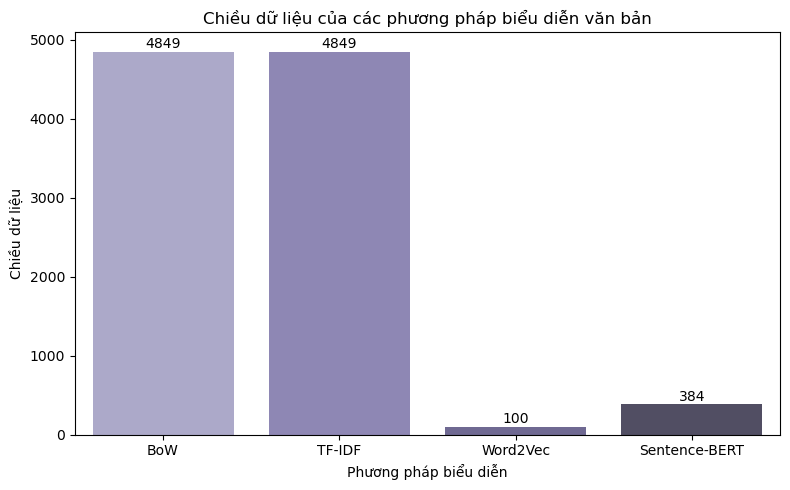

In [21]:
# Chiều dữ liệu
dims = {
    "BoW": X_bow.shape[1],
    "TF-IDF": X_tfidf.shape[1],
    "Word2Vec": X_w2v.shape[1],
    "Sentence-BERT": X_sbert.shape[1]
}

# Trực quan hóa chiều dữ liệu có giá trị ở mỗi cột
plt.figure(figsize=(8,5))
sns.barplot(x=list(dims.keys()), y=list(dims.values()), hue=list(dims.keys()), palette="Purples_d", legend=False)
for i, v in enumerate(dims.values()):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.title("Chiều dữ liệu của các phương pháp biểu diễn văn bản")
plt.ylabel("Chiều dữ liệu")
plt.xlabel("Phương pháp biểu diễn")
plt.tight_layout()
plt.show()

**Nhận xét:**
- BoW và TF-IDF: Có số chiều rất lớn (4849), tương ứng với số lượng từ vựng trong bộ từ điển. Điều này tạo ra "lời nguyền đa chiều" (curse of dimensionality), có thể gây ra khó khăn cho một số thuật toán học máy.
- Word2Vec: Có số chiều thấp nhất (100), giúp nén thông tin cực kỳ hiệu quả.
- Sentence-BERT: Có số chiều trung bình (384), cân bằng được giữa việc giữ lại thông tin ngữ nghĩa và tối ưu không gian biểu diễn.

#### 6.6.2 Độ thưa của dữ liệu

Độ thưa (sparsity) của một ma trận đặc trưng được sử dụng để đánh giá mức độ phân bố của các giá trị bằng 0 trong không gian biểu diễn văn bản. Trong nghiên cứu này, độ thưa được định nghĩa dựa trên tỷ lệ giữa số phần tử khác 0 và tổng số phần tử của ma trận đặc trưng, theo công thức:
$$\text{Sparsity} = 1 - \frac{\text{số phần tử khác 0}}{\text{tổng số phần tử}}$$
Cụ thể, với một ma trận đặc trưng $X \in \mathbb{R}^{n \times d}$, trong đó $n$ là số văn bản và $d$ là số chiều của vector biểu diễn, độ thưa được tính bằng:
```python
sparsity = 1 - (X.nnz / (X.shape[0] * X.shape[1]))
```
Trong đó:
- X.nnz là số phần tử khác 0 trong ma trận
- $X.shape[0] \times X.shape[1]$ là tổng số phần tử của ma trận.

Giá trị sparsity nằm trong khoảng $[0, 1]$, với:
- Sparsity gần 1: ma trận rất thưa (chứa nhiều giá trị 0), đặc trưng cho các biểu diễn dựa trên tần suất như Bag-of-Words và TF-IDF
- Sparsity gần 0: ma trận gần như đặc (hầu hết phần tử khác 0), đặc trưng cho các phương pháp embedding như Word2Vec và SBERT.

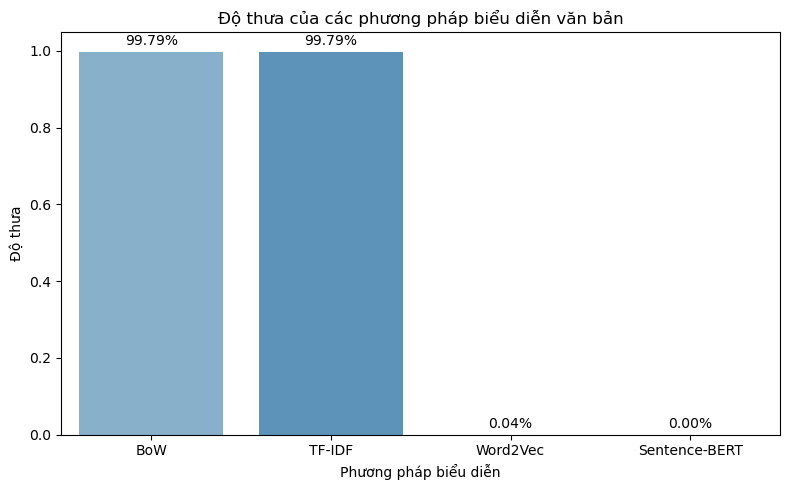

In [26]:
# Tính độ thưa 
sparcity = {
    "BoW": 1.0 - (X_bow.nnz / (X_bow.shape[0] * X_bow.shape[1])),
    "TF-IDF": 1.0 - (X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])),
    "Word2Vec": 1.0 - (np.count_nonzero(X_w2v) / (X_w2v.shape[0] * X_w2v.shape[1])),
    "Sentence-BERT": 1.0 - (np.count_nonzero(X_sbert) / (X_sbert.shape[0] * X_sbert.shape[1]))
}

# Trực quan hóa độ thưa của các phương pháp
plt.figure(figsize=(8,5))
sns.barplot(x=list(sparcity.keys()), y=list(sparcity.values()), hue=list(sparcity.keys()), palette="Blues_d", legend=False)
for i, v in enumerate(sparcity.values()):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', va='bottom')
plt.title("Độ thưa của các phương pháp biểu diễn văn bản")
plt.ylabel("Độ thưa")
plt.xlabel("Phương pháp biểu diễn")
plt.ylim(0, max(sparcity.values()) + 0.05)
plt.tight_layout()
plt.show()

**Nhận xét:**
- BoW và TF-IDF: Có độ thưa cực kỳ cao (99.79%). Điều này có nghĩa là gần như toàn bộ ma trận là các giá trị bằng 0, chỉ một phần rất nhỏ chứa thông tin thực tế.
- Nhóm Dense (Word2Vec, SBERT): Có độ thưa gần như bằng 0% (0.04% với Word2Vec và 0.00% với SBERT). Đây là các vector đặc, nơi mỗi vị trí trong vector đều mang một giá trị số thực đại diện cho một đặc trưng ngữ nghĩa nào đó.